# EE 467 Lab 2: Breaking CAPTCHAs with PyTorch

This is a PyTorch implementation of Lab 2, converted from the original TensorFlow/Keras version. The goal remains the same: automatically breaking CAPTCHAs using deep learning!

## Key Differences from TensorFlow Version:
- Uses PyTorch instead of TensorFlow/Keras
- Custom Dataset class for loading data
- Manual training loop instead of `.fit()`
- Different model definition syntax
- GPU support is more explicit in PyTorch

First, let's install the required libraries:

In [18]:
%pip install torch torchvision matplotlib scikit-learn "opencv-python>4" imutils

Note: you may need to restart the kernel to use updated packages.


## Imports

In [19]:
import os
import pickle
import glob
import math
from pprint import pprint

import cv2
import numpy as np
import imutils

from imutils import paths
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from lab_2_helpers import *

# Check PyTorch version and GPU availability
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

PyTorch version: 2.10.0
CUDA available: False
Using device: cpu


# Preprocessing
## Ground Truth Characters Extraction

In [20]:
!tar -xJf captcha-images.tar.xz

In [21]:
# Dataset images folder
CAPTCHA_IMAGE_FOLDER = "./captcha-images"

# List of all the captcha images we need to process
captcha_image_paths = list(paths.list_images(CAPTCHA_IMAGE_FOLDER))
# Review image paths
pprint(captcha_image_paths[:10])

['./captcha-images/G5P5.png',
 './captcha-images/5VXL.png',
 './captcha-images/4NL5.png',
 './captcha-images/4GGZ.png',
 './captcha-images/G7J9.png',
 './captcha-images/E6M8.png',
 './captcha-images/7WPB.png',
 './captcha-images/5TN5.png',
 './captcha-images/L6US.png',
 './captcha-images/2A5R.png']


In [22]:
def extract_captcha_text(image_path):
    """ Extract correct CAPTCHA texts from file name of images. """
    # Extract file name of image from its path
    # e.g. "./captcha-images/2A2X.png" -> "2A2X.png"
    image_file_name = os.path.basename(image_path)
    # Extract base name of image, omitting file extension
    # e.g. "2A2X.png" -> "2A2X"
    return os.path.splitext(image_file_name)[0]

captcha_texts = [extract_captcha_text(image_path) for image_path in captcha_image_paths]
# Review extraction results
pprint(captcha_texts[:10])

['G5P5', '5VXL', '4NL5', '4GGZ', 'G7J9', 'E6M8', '7WPB', '5TN5', 'L6US', '2A5R']


## Loading and Transforming Images

Figure(2000x500)


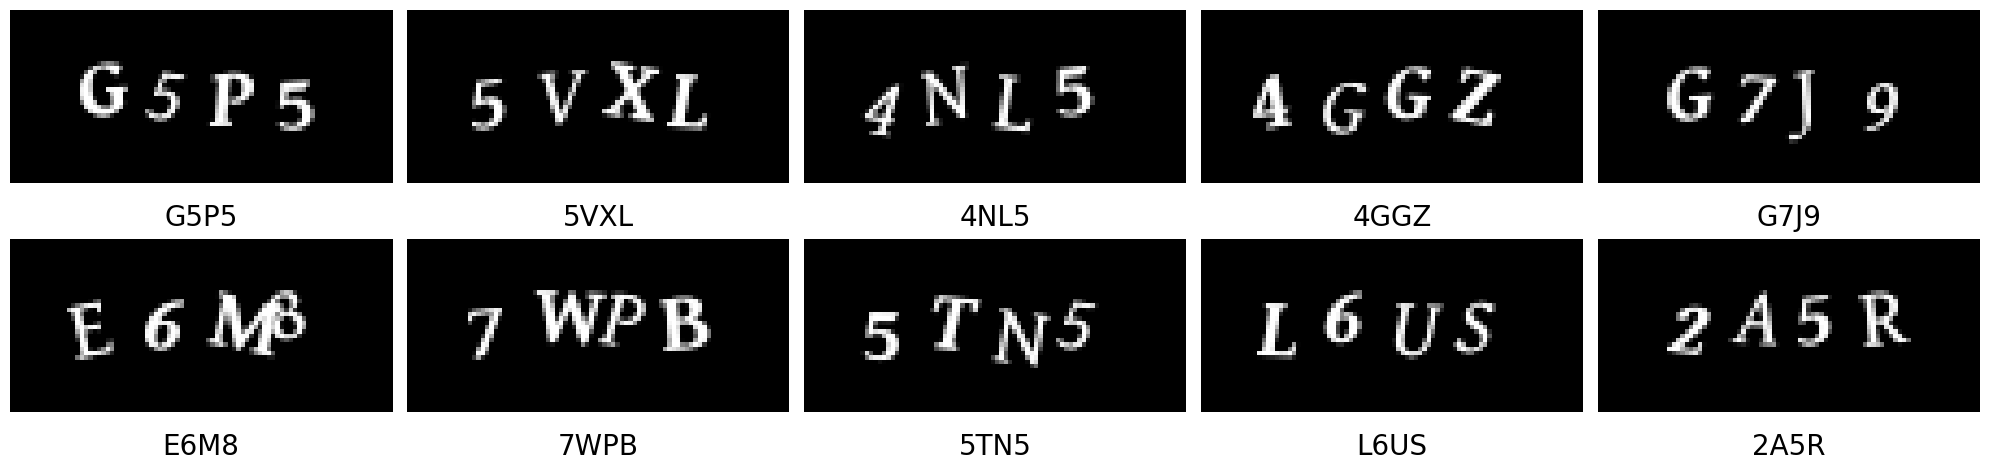

In [23]:
import cv2 as cv

def load_transform_image(image_path):
    """ Load and transform image into grayscale. """
    # 1) Load image with OpenCV
    image = cv.imread(image_path)

    # 2) Convert image to grayscale
    image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

    # 3) Add extra padding (8px) around the image
    image_padded = cv.copyMakeBorder(image_gray, 8, 8, 8, 8, cv.BORDER_CONSTANT, value=255)

    return image_padded

captcha_images = [load_transform_image(image_path) for image_path in captcha_image_paths]
# Review loaded CAPTCHAs
print_images(
    captcha_images[:10], n_rows=2, texts=captcha_texts[:10]
)

## Train-Validation-Test Split

In [24]:
# Train-validation-test split seed
TVT_SPLIT_SEED = 31528476

# Perform split on CAPTCHA images as well as labels
captcha_images_tv, captcha_images_test, captcha_texts_tv, captcha_texts_test = train_test_split(
    captcha_images, captcha_texts, test_size=0.2, random_state=TVT_SPLIT_SEED
)

print("Train-validation:", len(captcha_texts_tv))
print("Test:", len(captcha_texts_test))

Train-validation: 908
Test: 228


## Bounding Box Extraction

In [25]:
# Character images folder template
CHAR_IMAGE_FOLDER = f"./char-images-{TVT_SPLIT_SEED}"

def extract_chars(image):
    """ Find contours and extract characters inside each CAPTCHA. """
    # Threshold image and convert it to black-white
    image_bw = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    # Find contours (continuous blobs of pixels) the image
    contours = cv2.findContours(image_bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]

    char_regions = []
    # Loop through each contour
    for contour in contours:
        # Get the rectangle that contains the contour
        x, y, w, h = cv2.boundingRect(contour)

        # Compare the width and height of the bounding box,
        # detect if there are letters conjoined into one chunk
        if w / h > 1.25:
            # Bounding box is too wide for a single character
            # Split it in half into two letter regions
            half_width = int(w / 2)
            char_regions.append((x, y, half_width, h))
            char_regions.append((x + half_width, y, half_width, h))
        else:
            # Only a single letter in contour
            char_regions.append((x, y, w, h))

    # Ignore image if less or more than 4 regions detected
    if len(char_regions) != 4:
        return None
    # Sort regions by their X coordinates
    char_regions.sort(key=lambda x: x[0])

    # Character images
    char_images = []
    # Save each character as a single image
    for x, y, w, h in char_regions:
        # Extract character from image with 2px margin
        char_image = image[y - 2:y + h + 2, x - 2:x + w + 2]
        # Save character images
        char_images.append(char_image)

    # Return character images
    return char_images

def save_chars(char_images, captcha_text, save_dir, char_counts):
    """ Save character images to directory. """
    for char_image, char in zip(char_images, captcha_text):
        # Get the folder to save the image in
        save_path = os.path.join(save_dir, char)
        os.makedirs(save_path, exist_ok=True)

        # Write letter image to file
        char_count = char_counts.get(char, 1)
        char_image_path = os.path.join(save_path, f"{char_count}.png")
        cv2.imwrite(char_image_path, char_image)

        # Update count
        char_counts[char] = char_count + 1

# Force character extraction even if results are already available
FORCE_EXTRACT_CHAR = False

char_counts = {}
# Extract and save images for characters
if FORCE_EXTRACT_CHAR or not os.path.exists(CHAR_IMAGE_FOLDER):
    print("Extracting characters...")
    for captcha_image, captcha_text in zip(captcha_images_tv, captcha_texts_tv):
        # Extract character images
        char_images = extract_chars(captcha_image)
        # Skip if extraction failed
        if char_images is None:
            continue
        # Save character images
        save_chars(char_images, captcha_text, CHAR_IMAGE_FOLDER, char_counts)
    print("Character extraction complete!")
else:
    print("Using existing character images.")

Using existing character images.


## Label Encoding

In [26]:
# Path of occurred characters (labels)
LABELS_PATH = "./labels.pkl"

def make_feature(image):
    """ Process character image and turn it into feature. """
    # Resize letter to 20*20
    image_resized = resize_to_fit(image, 20, 20)
    # Add extra dimension as the only channel
    feature = image_resized[..., None]

    return feature

def make_feature_label(image_path):
    """ Load character image and make feature-label pair from image path. """
    # Load image and make feature
    feature = make_feature(cv2.imread(image_path, cv2.IMREAD_GRAYSCALE))
    # Extract label based on the directory the image is in
    label = image_path.split(os.path.sep)[-2]

    return feature, label

# Make features and labels from character image paths
features_tv, labels_tv = unzip((make_feature_label(image_path) 
                                for image_path in paths.list_images(CHAR_IMAGE_FOLDER)))

# Scale raw pixel values into range [0, 1]
features_tv = np.array(features_tv, dtype="float32") / 255

# Convert labels into one-hot encodings
lb = LabelBinarizer()
labels_one_hot_tv = lb.fit_transform(labels_tv)
# Number of classes
n_classes = len(lb.classes_)

print(f"Number of classes: {n_classes}")
print(f"Classes: {lb.classes_}")

# Further split the training data into training and validation set
X_train, X_vali, y_train, y_vali = train_test_split(
    features_tv, labels_one_hot_tv, test_size=0.25, random_state=955996
)

# Save mapping from labels to one-hot encoding
with open(LABELS_PATH, "wb") as f:
    pickle.dump(lb, f)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_vali)}")

Number of classes: 32
Classes: ['2' '3' '4' '5' '6' '7' '8' '9' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'J' 'K'
 'L' 'M' 'N' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z']
Training samples: 2676
Validation samples: 892


# Training

## PyTorch Dataset Class

Unlike TensorFlow/Keras, PyTorch uses custom Dataset classes for data loading:

In [27]:
class CaptchaDataset(Dataset):
    """Custom Dataset for CAPTCHA character images."""
    
    def __init__(self, features, labels):
        """
        Args:
            features: numpy array of shape (N, 20, 20, 1)
            labels: numpy array of shape (N, n_classes) - one-hot encoded
        """
        # PyTorch expects channels first: (N, C, H, W)
        # Convert from (N, H, W, C) to (N, C, H, W)
        self.features = torch.FloatTensor(features).permute(0, 3, 1, 2)
        self.labels = torch.FloatTensor(labels)
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Create datasets
train_dataset = CaptchaDataset(X_train, y_train)
vali_dataset = CaptchaDataset(X_vali, y_vali)

# Batch size
BATCH_SIZE = 32

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
vali_loader = DataLoader(vali_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(vali_loader)}")

Number of training batches: 84
Number of validation batches: 28


## PyTorch Model Definition

Now we'll build the same CNN architecture in PyTorch. The structure is:

1. Conv2D (20 filters, 5x5) + ReLU + MaxPool2D (2x2)
2. Conv2D (50 filters, 5x5) + ReLU + MaxPool2D (2x2)
3. Flatten
4. Fully Connected (500 units) + ReLU
5. Fully Connected (n_classes units) + Softmax

In [28]:
class CaptchaCNN(nn.Module):
    """Convolutional Neural Network for CAPTCHA character classification."""
    
    def __init__(self, n_classes):
        super(CaptchaCNN, self).__init__()
        
        # First convolution block
        # Input: (batch_size, 1, 20, 20)
        # Output after conv: (batch_size, 20, 20, 20)
        # Output after pool: (batch_size, 20, 10, 10)
        self.conv1 = nn.Conv2d(
            in_channels=1, 
            out_channels=20, 
            kernel_size=5, 
            padding=2  # 'same' padding
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Second convolution block
        # Input: (batch_size, 20, 10, 10)
        # Output after conv: (batch_size, 50, 10, 10)
        # Output after pool: (batch_size, 50, 5, 5)
        self.conv2 = nn.Conv2d(
            in_channels=20, 
            out_channels=50, 
            kernel_size=5, 
            padding=2  # 'same' padding
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        # After flattening: (batch_size, 50 * 5 * 5) = (batch_size, 1250)
        self.fc1 = nn.Linear(50 * 5 * 5, 500)
        self.fc2 = nn.Linear(500, n_classes)
        
    def forward(self, x):
        # First convolution block
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        
        # Second convolution block
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        
        # Flatten
        x = x.view(x.size(0), -1)  # Flatten: (batch_size, 50*5*5)
        
        # Fully connected layers
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        
        # Softmax is included in CrossEntropyLoss in PyTorch
        # So we don't apply it here during training
        return x

# Create model instance
model = CaptchaCNN(n_classes).to(device)

# Print model architecture
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")

CaptchaCNN(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1250, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=32, bias=True)
)

Total parameters: 667102


## Training Loop

PyTorch requires us to write the training loop manually (unlike Keras's `.fit()` method):

In [29]:
# Number of epochs
N_EPOCHS = 10

# Path of model weights file
MODEL_WEIGHTS_PATH = "./captcha-model-pytorch.pth"
# Force training even if weights are already available
FORCE_TRAINING = True

# Define loss function and optimizer
# Note: CrossEntropyLoss includes softmax, so we don't apply it in forward()
# However, our labels are one-hot encoded, so we need to convert them
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (features, labels) in enumerate(train_loader):
        # Move data to device
        features = features.to(device)
        # Convert one-hot to class indices for CrossEntropyLoss
        labels = torch.argmax(labels, dim=1).to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(features)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

def validate(model, vali_loader, criterion, device):
    """Validate the model."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for features, labels in vali_loader:
            # Move data to device
            features = features.to(device)
            # Convert one-hot to class indices
            labels = torch.argmax(labels, dim=1).to(device)
            
            # Forward pass
            outputs = model(features)
            loss = criterion(outputs, labels)
            
            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(vali_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

# Training
if FORCE_TRAINING or not os.path.exists(MODEL_WEIGHTS_PATH):
    print("Training the model...\n")
    
    for epoch in range(N_EPOCHS):
        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # Validate
        vali_loss, vali_acc = validate(model, vali_loader, criterion, device)
        
        # Print statistics
        print(f"Epoch [{epoch+1}/{N_EPOCHS}]")
        print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"  Val Loss: {vali_loss:.4f}, Val Acc: {vali_acc:.2f}%")
    
    # Save model weights
    torch.save(model.state_dict(), MODEL_WEIGHTS_PATH)
    print(f"\nModel saved to {MODEL_WEIGHTS_PATH}")
else:
    # Load existing weights
    model.load_state_dict(torch.load(MODEL_WEIGHTS_PATH, map_location=device))
    print(f"Loaded model weights from {MODEL_WEIGHTS_PATH}")

Training the model...

Epoch [1/10]
  Train Loss: 2.0231, Train Acc: 45.48%
  Val Loss: 0.3897, Val Acc: 91.59%
Epoch [2/10]
  Train Loss: 0.1885, Train Acc: 96.41%
  Val Loss: 0.1301, Val Acc: 97.31%
Epoch [3/10]
  Train Loss: 0.0777, Train Acc: 98.28%
  Val Loss: 0.1007, Val Acc: 98.21%
Epoch [4/10]
  Train Loss: 0.0312, Train Acc: 99.22%
  Val Loss: 0.0971, Val Acc: 98.65%
Epoch [5/10]
  Train Loss: 0.0240, Train Acc: 99.44%
  Val Loss: 0.0911, Val Acc: 98.54%
Epoch [6/10]
  Train Loss: 0.0171, Train Acc: 99.51%
  Val Loss: 0.0740, Val Acc: 98.99%
Epoch [7/10]
  Train Loss: 0.0071, Train Acc: 99.85%
  Val Loss: 0.0791, Val Acc: 98.65%
Epoch [8/10]
  Train Loss: 0.0019, Train Acc: 100.00%
  Val Loss: 0.0731, Val Acc: 98.99%
Epoch [9/10]
  Train Loss: 0.0007, Train Acc: 100.00%
  Val Loss: 0.0788, Val Acc: 98.99%
Epoch [10/10]
  Train Loss: 0.0005, Train Acc: 100.00%
  Val Loss: 0.0812, Val Acc: 98.99%

Model saved to ./captcha-model-pytorch.pth


# Evaluation

Now let's test the complete CAPTCHA breaking pipeline end-to-end:

In [30]:
# Load labels from file
with open(LABELS_PATH, "rb") as f:
    lb = pickle.load(f)

# Dummy character images
DUMMY_CHAR_IMAGES = np.zeros((4, 20, 20, 1))

# Indices of CAPTCHAs on which extractions failed
extract_failed_indices = []
# Extracted character images
char_images_test = []

# Extract character images and make features
for i, captcha_image in enumerate(captcha_images_test):
    # Extract character images
    char_images = extract_chars(captcha_image)

    if char_images:
        char_images_test.extend(char_images)
    # Use dummy character images as placeholder if extraction failed
    else:
        extract_failed_indices.append(i)
        char_images_test.extend(DUMMY_CHAR_IMAGES)

# Make features for character images
features_test = [make_feature(char_image) for char_image in char_images_test]
# Scale raw pixel values into range [0, 1]
features_test = np.array(features_test, dtype="float32") / 255

# Convert to PyTorch tensor and move to device
# Convert from (N, H, W, C) to (N, C, H, W)
features_test_tensor = torch.FloatTensor(features_test).permute(0, 3, 1, 2).to(device)

# Predict labels with neural network
model.eval()
with torch.no_grad():
    outputs = model(features_test_tensor)
    # Apply softmax to get probabilities
    probabilities = F.softmax(outputs, dim=1)
    # Get predictions
    _, predicted_indices = torch.max(probabilities, 1)
    predicted_indices = predicted_indices.cpu().numpy()

# Convert indices to characters
preds_test = lb.classes_[predicted_indices]

# Group all 4 characters for the same CAPTCHA
preds_test = ["".join(chars) for chars in group_every(preds_test, 4)]
# Update result for CAPTCHAs on which extractions failed
for i in extract_failed_indices:
    preds_test[i] = "-"

## Compute Accuracy and Display Results

# of test CAPTCHAs: 228
# correctly recognized: 218
Accuracy: 0.956140350877193 

Correct Predictions:
Figure(2000x500)

Incorrect Predictions:
Figure(2000x600)


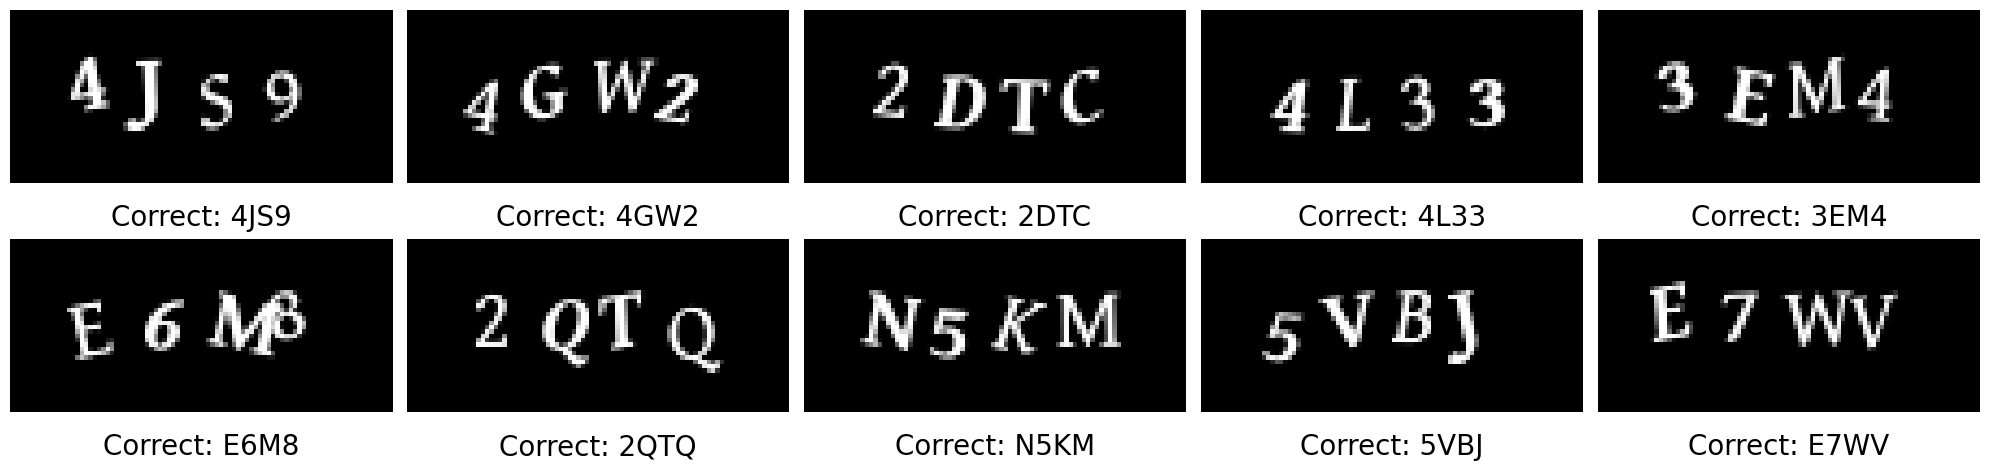

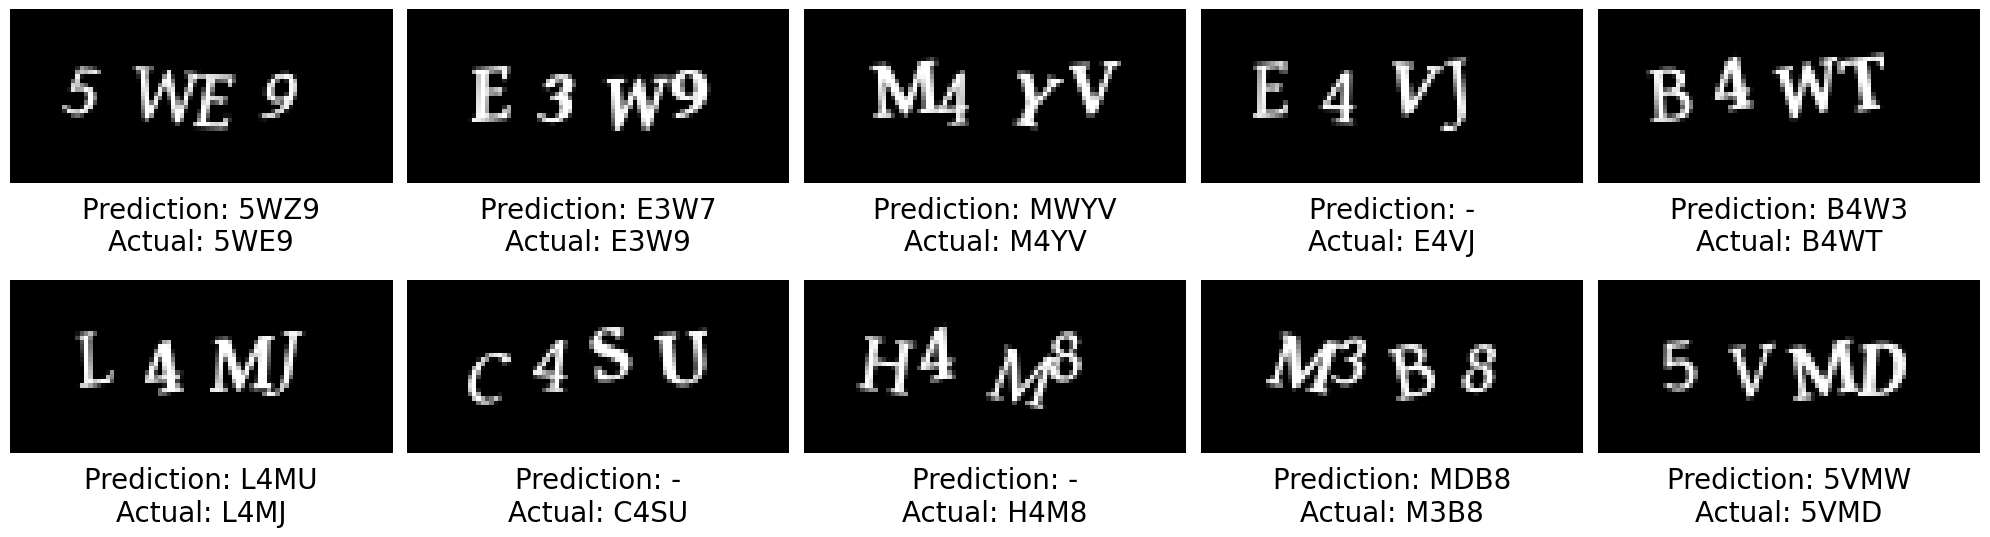

In [31]:
# Number of CAPTCHAs to display
N_DISPLAY_SAMPLES = 10

# Number of test CAPTCHAs
n_test = len(captcha_texts_test)
# Number of correct predictions
n_correct = 0

# Indices of correct predictions
correct_indices = []
# Indices of incorrect predictions
incorrect_indices = []

for i, (pred_text, actual_text) in enumerate(zip(preds_test, captcha_texts_test)):
    if pred_text == actual_text:
        # Update number of correct predictions
        n_correct = n_correct + 1
        # Collect index of correct prediction
        if len(correct_indices) < N_DISPLAY_SAMPLES:
            correct_indices.append(i)
    else:
        # Collect index of incorrect prediction
        if len(incorrect_indices) < N_DISPLAY_SAMPLES:
            incorrect_indices.append(i)

# Show number of total / correct predictions and accuracy
print("# of test CAPTCHAs:", n_test)
print("# correctly recognized:", n_correct)
print("Accuracy:", n_correct/n_test, "\n")

# Show all correct predictions
print("Correct Predictions:")
print_images(
    [captcha_images_test[i] for i in correct_indices],
    texts=[f"Correct: {captcha_texts_test[i]}" for i in correct_indices],
    n_rows=2
)

# Show all incorrect predictions
print("\nIncorrect Predictions:")
print_images(
    [captcha_images_test[i] for i in incorrect_indices],
    texts=[
        f"Prediction: {preds_test[i]}\nActual: {captcha_texts_test[i]}" \
        for i in incorrect_indices
    ],
    n_rows=2,
    fig_size=(20, 6),
    text_center=(0.5, -0.25)
)

## Summary

### Key Differences Between TensorFlow and PyTorch Implementations:

1. **Data Loading:**
   - TensorFlow/Keras: Direct numpy arrays to `.fit()`
   - PyTorch: Custom `Dataset` class + `DataLoader`

2. **Model Definition:**
   - TensorFlow/Keras: `Sequential()` with `.add()` layers
   - PyTorch: Custom `nn.Module` class with `forward()` method

3. **Training:**
   - TensorFlow/Keras: `.fit()` handles everything
   - PyTorch: Manual training loop with gradient computation

4. **Loss Function:**
   - TensorFlow/Keras: Categorical crossentropy (separate from model)
   - PyTorch: `CrossEntropyLoss` (includes softmax)

5. **Data Format:**
   - TensorFlow/Keras: Channels last (H, W, C)
   - PyTorch: Channels first (C, H, W)

### Performance:

Both implementations should achieve similar accuracy (~95-98%) on this CAPTCHA dataset. Minor differences may occur due to:
- Random initialization
- Different optimization implementations
- Floating point precision

### Advantages of Each Framework:

**TensorFlow/Keras:**
- Simpler high-level API
- Less boilerplate code
- Better for beginners

**PyTorch:**
- More flexibility and control
- Better for research and custom architectures
- More Pythonic and intuitive
- Easier debugging with standard Python tools

## References
1. PyTorch Documentation: https://pytorch.org/docs/stable/index.html
2. PyTorch Tutorials: https://pytorch.org/tutorials/
3. Original TensorFlow Implementation: lab_2_AidanFrondozo.ipynb
4. How to break a CAPTCHA system in 15 minutes with Machine Learning: https://medium.com/@ageitgey/how-to-break-a-captcha-system-in-15-minutes-with-machine-learning-dbebb035a710